In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn 
from torch.utils.data import DataLoader     # 데이터로더는 데이터셋을 iterable하게 감싸는 역할

from torchvision import datasets            # 데이터셋은 샘플과 정답을 저장함
from torchvision.transforms import ToTensor

import clip

from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

## Our Model

In [3]:
import deeplake
from torchvision import transforms, models

ds_train = deeplake.load('hub://activeloop/pacs-train')
ds_test = deeplake.load('hub://activeloop/pacs-test')

c:\Users\alllh\anaconda3\envs\dev\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.2.9) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


hub://activeloop/pacs-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train
hub://activeloop/pacs-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-test


In [4]:
batch_size = 8

tform = transforms.Compose([
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    # transforms.Normalize([0.5], [0.5]),
])

train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, 
                                transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})

In [5]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    plt.figure(figsize=(10, 100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

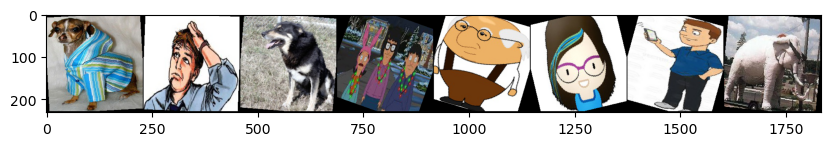

torch.Size([8, 3, 227, 227])


In [6]:
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images, nrow=8))
print(images.shape)

In [7]:
# image data -> iamge_features
# class data -> class_features  (fixed!)
# label data 
# image sim class -> label

def get_image_features(clip_model, images):
    num_image_layer = clip_model.visual.transformer.layers
    images = images.to(device)

    out_list = []
    x = clip_model.visual.conv1(images.type(clip_model.dtype))
    x = x.reshape(x.shape[0], x.shape[1], -1)   # shape = [*, width, grid ** 2]
    x = x.permute(0, 2, 1)                      # shape = [*, grid ** 2, width]
    x = torch.cat([clip_model.visual.class_embedding.to(x.dtype) + 
                   torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
    x = x + clip_model.visual.positional_embedding.to(x.dtype)
    x = clip_model.visual.ln_pre(x)
    x = x.permute(1, 0, 2)          # NLD -> LND

    for i in range(num_image_layer):
        x = clip_model.visual.transformer.resblocks[i](x)
        tmp = x.permute(1, 0, 2)    # LND -> NLD
        tmp = tmp[:, 0, :].detach()
        out_list.append(tmp)

    image_features = torch.stack(out_list)

    return image_features

def get_text_features(clip_model, texts):
    num_text_layer = clip_model.transformer.layers
    texts = texts.to(device)

    out_list = []
    x = clip_model.token_embedding(texts).type(clip_model.dtype)  # [batch_size, n_ctx, d_clip_model]
    x = x + clip_model.positional_embedding.type(clip_model.dtype)
    x = x.permute(1, 0, 2)                  # NLD -> LND

    for i in range(num_text_layer):
        x = clip_model.transformer.resblocks[i](x)
        tmp = x.permute(1, 0, 2).detach()   # LND -> NLD
        out_list.append(tmp)

    text_features = torch.stack(out_list)

    return text_features

In [8]:
image_features = get_image_features(clip_model, images)
image_features.shape

torch.Size([12, 8, 768])

In [9]:
pacs_class = [
    'a dog', 'an elephant', 'a giraffe', 'a guitar', 'a horse', 'a house', 'a person'
]

def prompt(idx):
    return f"An image of {pacs_class[idx]}"

prompts = [prompt(x) for x in range(7)]
class_tokens = clip.tokenize([prompt(x) for x in range(7)]).to(device)
print(prompts)

['An image of a dog', 'An image of an elephant', 'An image of a giraffe', 'An image of a guitar', 'An image of a horse', 'An image of a house', 'An image of a person']


In [10]:
class_features = get_text_features(clip_model, class_tokens)
class_features.shape

torch.Size([12, 7, 77, 512])

#### inference

In [11]:
image_features2 = clip_model.visual.ln_post(image_features)                   # (12, batch_size, 768)
image_embeddings = image_features2 @ clip_model.visual.proj      # (12, batch_size, 512)  <- we'll use it

class_features2 = clip_model.ln_final(class_features).type(clip_model.dtype)   # (12, seq_len, 77, 512)
class_embeddings = class_features2[:, torch.arange(class_features2.shape[1]), class_tokens.argmax(dim=-1)] @ clip_model.text_projection
                                                                # (12, seq_len, 512)  <- we'll use it

score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)


In [12]:
# torch.max(score_tensor, dim=-1)[0]
# torch.mean(score_tensor, dim=-1)
# torch.sum(torch.sigmoid(100 * score_tensor.clone().normal_()), dim=-1)
# torch.softmax(score_tensor, dim=-1).exp().sum(dim=-1)
torch.sigmoid(100 * score_tensor.clone().normal_()).sum(dim=-1)

tensor([[74.1250, 59.9375, 69.5625, 71.7500, 75.9375, 65.6875, 70.5625],
        [69.1875, 74.0625, 66.1875, 80.5625, 76.6250, 73.9375, 76.1250],
        [73.6875, 72.4375, 80.6875, 68.1875, 80.8750, 68.0625, 68.5000],
        [67.0000, 72.1250, 72.9375, 67.5625, 76.6250, 66.6875, 79.5625],
        [69.5000, 78.3750, 81.0625, 61.8125, 67.6250, 75.2500, 71.2500],
        [66.6250, 70.8125, 66.9375, 66.9375, 67.6250, 76.9375, 70.7500],
        [79.0625, 66.8125, 65.5625, 73.6250, 70.1875, 74.1875, 78.3125],
        [77.7500, 71.6250, 80.6250, 75.7500, 76.7500, 65.6250, 84.4375]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SumBackward1>)

In [86]:
torch.tanh(torch.randn_like(clip_model.visual.proj, dtype=torch.float16)).max()
clip_model.visual.proj.min(), clip_model.visual.proj.max()
(torch.randn_like(clip_model.visual.proj, dtype=torch.float16, requires_grad=True)/50)


tensor([[ 0.0007, -0.0222, -0.0106,  ...,  0.0380,  0.0129, -0.0047],
        [-0.0048, -0.0150,  0.0056,  ...,  0.0154, -0.0073,  0.0186],
        [-0.0041,  0.0072, -0.0206,  ...,  0.0056,  0.0062,  0.0109],
        ...,
        [ 0.0036,  0.0110, -0.0063,  ..., -0.0035, -0.0166, -0.0372],
        [-0.0275,  0.0010, -0.0130,  ...,  0.0269,  0.0084,  0.0074],
        [-0.0164, -0.0098,  0.0093,  ..., -0.0162, -0.0254,  0.0229]],
       device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)

In [87]:
# Define model
class OurCLIP(nn.Module):        
    def __init__(self, clip_model, # use pre-trained clip model
                 use_one_ln1=True, use_one_ln2=True, 
                 use_one_projection1=True, use_one_projection2=True,
                 trainable_ln1=False, trainable_ln2=False, 
                 trainable_projection1=False, trainable_projection2=False,
                 threshold = 20, score_type=0): 
        super().__init__()

        self.dtype = clip_model.dtype
        self.threshold = threshold
        self.score_type = score_type

        ####################### 미구현
        if use_one_ln1:
            self.ln_post = clip_model.visual.ln_post.requires_grad_(trainable_ln1)
        else: pass
        if use_one_ln2:
            self.ln_final = clip_model.ln_final.requires_grad_(trainable_ln2)
        else: pass
        ########################

        if use_one_projection1:
            self.visual_projection = nn.Parameter(clip_model.visual.proj.clone().detach()).requires_grad_(True)
            if not trainable_projection1:
                self.visual_projection = nn.Parameter(clip_model.visual.proj.clone().detach()).requires_grad_(False)
        else:
            self.visual_projection = nn.Parameter(
                torch.stack([
                    torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                    clip_model.visual.proj.clone().detach()
                ])).requires_grad_(True)
            # self.visual_projection = nn.Parameter(torch.stack([*[torch.rand(clip_model.visual.proj.shape).to(device) for _ in range(11)],
            #                                        clip_model.visual.proj.clone()]).detach()).type(torch.float16).requires_grad_(True)
        
        if use_one_projection2:
            self.textual_projection = nn.Parameter(clip_model.text_projection.clone().detach()).requires_grad_(True)
            if not trainable_projection2:
                self.textual_projection = nn.Parameter(clip_model.text_projection.clone().detach()).requires_grad_(False)
        else:
            self.textual_projection = nn.Parameter(
                torch.stack([
                    torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                    torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                    clip_model.text_projection.clone().detach()
                ])).requires_grad_(True)
            # self.textual_projection = nn.Parameter(torch.stack([*[torch.rand(clip_model.text_projection.shape).to(device) for _ in range(11)], 
            #                                        clip_model.text_projection.clone()]).detach()).type(torch.float16).requires_grad_(True)


    def forward(self, image_features, class_features, class_tokens):    
        image_features2 = self.ln_post(image_features)                     # (12, batch_size, 768)
        image_embeddings = image_features2 @ self.visual_projection        # (12, batch_size, 512)  <- we'll use it

        class_features2 = self.ln_final(class_features).type(self.dtype)    # (12, seq_len, 77, 512)
        class_embeddings = class_features2[:, torch.arange(class_features2.shape[1]), class_tokens.argmax(dim=-1)] @ self.textual_projection
                                                                                        # (12, seq_len, 512)  <- we'll use it

        score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
        score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)

        if self.score_type == 1:
            return torch.mean(score_tensor, dim=-1)
        if self.score_type == 2:
            return torch.sigmoid(100 * score_tensor.normal_()).sum(dim=-1)
        return torch.max(score_tensor, dim=-1)[0]

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

model = OurCLIP(clip_model, trainable_projection1=True, trainable_projection2=True).to(device)  # model을 initialize하는 부분
print(model)

OurCLIP(
  (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (ln_final): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)


In [15]:
for name, param in model.named_parameters():
    print(name, param.shape)

visual_projection torch.Size([768, 512])
textual_projection torch.Size([512, 512])
ln_post.weight torch.Size([768])
ln_post.bias torch.Size([768])
ln_final.weight torch.Size([512])
ln_final.bias torch.Size([512])


## Train

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1) # momentum

In [101]:
import time

def train_one_epoch(clip_model, model, optimizer, data_loader, device, max_iter_num=3000):

    model.train()

    # Zero the performance stats for each epoch
    running_loss = 0.0
    start_time = time.time()
    total = 0
    correct = 0
    loss_before = 1000000
    
    for i, data in enumerate(data_loader):
        images = data['images']
        labels = torch.squeeze(data['labels'])

        images = images.to(device)
        labels = labels.to(device)

        image_features = get_image_features(clip_model, images)
        
        optimizer.zero_grad()
        
        output = model(image_features, class_features, class_tokens)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(output, dim=-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
        # Print performance statistics
        running_loss += loss.item()
        if i != 0 and i % 10 == 0:    # print every 10 batches
            batch_time = time.time()
            speed = (i+1)/(batch_time-start_time)
            print('[%5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                  (i, running_loss, speed, accuracy))

            running_loss = 0.0
            total = 0
            correct = 0
        if i != 0 and i % max_iter_num == 0:
            break;

    
def test_model(clip_model, model, data_loader, max_iter_num=100):

    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # get the images; data is a list of [images, labels]
            images = data['images']
            labels = torch.squeeze(data['labels'])

            images = images.to(device)
            labels = labels.to(device)

            image_features = get_image_features(clip_model, images)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(image_features, class_features, class_tokens)

            predicted = torch.argmax(output, dim=-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
            if i != 0 and i % max_iter_num == 0:
                break
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))

### inference

In [18]:
batch_size = 32

train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, 
                                transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})

In [22]:
# train all by one tensor / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 3
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)

    test_model(clip_model, model, test_loader, max_iter_num=100)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 0.625, speed: 0.09, accuracy: 75.00 %
[   10] loss: 0.433, speed: 0.46, accuracy: 98.75 %
[   20] loss: 0.115, speed: 0.58, accuracy: 100.00 %
[   30] loss: 0.358, speed: 0.63, accuracy: 98.75 %
[   40] loss: 0.651, speed: 0.59, accuracy: 96.88 %
[   50] loss: 0.727, speed: 0.66, accuracy: 97.50 %
[   60] loss: 0.536, speed: 0.72, accuracy: 98.12 %
[   70] loss: 2.043, speed: 0.70, accuracy: 93.44 %
[   80] loss: 0.898, speed: 0.74, accuracy: 96.56 %
[   90] loss: 1.960, speed: 0.75, accuracy: 92.19 %
[  100] loss: 2.576, speed: 0.80, accuracy: 89.69 %
[  110] loss: 4.451, speed: 0.84, accuracy: 85.62 %
[  120] loss: 3.186, speed: 0.87, accuracy: 87.81 %
[  130] loss: 3.400, speed: 0.90, accuracy: 88.12 %
[  140] loss: 1.587, speed: 0.94, accuracy: 94.38 %
[  150] loss: 1.716, speed: 0.96, accuracy: 93.12 %
[  160] loss: 3.473, speed: 0.99, accuracy: 87.50 %
[  170] loss: 1.672, speed: 1.02, accuracy: 93.44 %
[  180] 

In [88]:
# train all by one tensor / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 3

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)

    test_model(clip_model, model, test_loader, max_iter_num=100)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 1.240, speed: 0.11, accuracy: 31.25 %
[   10] loss: 7.241, speed: 0.74, accuracy: 76.25 %
[   20] loss: 4.228, speed: 1.00, accuracy: 92.50 %
[   30] loss: 1.439, speed: 1.14, accuracy: 99.06 %
[   40] loss: 5.987, speed: 1.08, accuracy: 85.94 %
[   50] loss: 10.446, speed: 1.15, accuracy: 48.12 %
[   60] loss: 31.554, speed: 1.09, accuracy: 48.44 %
[   70] loss: 26.225, speed: 1.14, accuracy: 47.19 %
[   80] loss: 14.267, speed: 1.08, accuracy: 51.25 %
[   90] loss: 12.118, speed: 1.12, accuracy: 61.25 %
[  100] loss: 18.549, speed: 1.06, accuracy: 63.44 %
[  110] loss: 16.831, speed: 1.10, accuracy: 55.62 %
[  120] loss: 12.041, speed: 1.06, accuracy: 63.12 %
[  130] loss: 13.233, speed: 1.09, accuracy: 53.12 %
[  140] loss: 9.333, speed: 1.11, accuracy: 62.50 %
[  150] loss: 14.177, speed: 1.09, accuracy: 54.69 %
[  160] loss: 13.762, speed: 1.11, accuracy: 38.44 %
[  170] loss: 11.584, speed: 1.13, accuracy: 51.56

In [91]:
# train all by one tensor / count_score 
# reference: https://discuss.pytorch.org/t/is-there-any-soft-way-of-counting-positive-values-with-grad-reserved/158975/2
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=2).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 3

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)

    test_model(clip_model, model, test_loader, max_iter_num=100)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 8.461, speed: 0.10, accuracy: 12.50 %
[   10] loss: 80.953, speed: 0.65, accuracy: 12.81 %
[   20] loss: 83.559, speed: 0.89, accuracy: 10.62 %
[   30] loss: 82.422, speed: 0.84, accuracy: 12.81 %
[   40] loss: 86.867, speed: 0.93, accuracy: 14.69 %
[   50] loss: 82.734, speed: 0.89, accuracy: 14.69 %
[   60] loss: 82.469, speed: 0.96, accuracy: 15.31 %
[   70] loss: 75.145, speed: 1.02, accuracy: 14.06 %
[   80] loss: 87.430, speed: 1.06, accuracy: 12.50 %
[   90] loss: 87.059, speed: 1.10, accuracy: 13.44 %
[  100] loss: 87.695, speed: 1.13, accuracy: 11.56 %
[  110] loss: 83.094, speed: 1.16, accuracy: 12.19 %
[  120] loss: 81.738, speed: 1.17, accuracy: 13.44 %
[  130] loss: 86.961, speed: 1.19, accuracy: 12.19 %
[  140] loss: 83.777, speed: 1.15, accuracy: 12.19 %
[  150] loss: 82.941, speed: 1.16, accuracy: 15.31 %
[  160] loss: 85.008, speed: 1.13, accuracy: 11.25 %
[  170] loss: 77.586, speed: 1.15, accuracy: 

In [48]:
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분
# (image_features2 @ model.visual_projection).shape
image_features2.shape, model.visual_projection.shape

(torch.Size([12, 8, 768]), torch.Size([12, 768, 512]))

In [49]:
# train all by each tensor(init with last weight) / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 3

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)

    test_model(clip_model, model, test_loader, max_iter_num=100)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 1.978, speed: 0.10, accuracy: 46.88 %
[   10] loss: 0.728, speed: 0.71, accuracy: 97.81 %
[   20] loss: 0.481, speed: 0.99, accuracy: 98.75 %
[   30] loss: 1.062, speed: 0.90, accuracy: 95.31 %
[   40] loss: 0.472, speed: 1.02, accuracy: 98.75 %
[   50] loss: 0.164, speed: 1.11, accuracy: 99.38 %
[   60] loss: 0.119, speed: 1.18, accuracy: 99.69 %
[   70] loss: 0.591, speed: 1.09, accuracy: 98.44 %
[   80] loss: 0.443, speed: 1.14, accuracy: 99.06 %
[   90] loss: 0.547, speed: 1.08, accuracy: 99.38 %
[  100] loss: 0.343, speed: 1.12, accuracy: 99.06 %
[  110] loss: 1.080, speed: 1.08, accuracy: 96.25 %
[  120] loss: 1.512, speed: 1.11, accuracy: 94.06 %
[  130] loss: 9.431, speed: 1.09, accuracy: 76.56 %
[  140] loss: 5.897, speed: 1.11, accuracy: 83.75 %
[  150] loss: 2.508, speed: 1.14, accuracy: 92.19 %
[  160] loss: 2.003, speed: 1.16, accuracy: 94.06 %
[  170] loss: 3.111, speed: 1.18, accuracy: 90.31 %
[  180] l

In [52]:
# 의도한 대로 학습되었는지 확인하기
model.visual_projection[0], model.visual_projection[1]

(tensor([[-2.6264e-03,  4.9829e-05,  2.7496e-02,  ..., -1.0025e-02,
          -1.2222e-02,  5.8403e-03],
         [-1.9852e-02,  7.1564e-03,  8.6784e-04,  ...,  1.1475e-02,
          -1.9485e-02, -8.0185e-03],
         [-8.6288e-03,  1.9150e-03, -2.1725e-03,  ...,  3.9368e-03,
          -1.1269e-02,  1.5306e-03],
         ...,
         [-1.1993e-02,  1.2955e-02,  2.5848e-02,  ..., -9.8038e-03,
          -4.2076e-03,  1.5199e-04],
         [-1.2871e-02, -9.5673e-03, -1.0826e-02,  ..., -7.0381e-03,
          -4.3182e-03, -5.0306e-04],
         [-4.4098e-03,  3.3588e-03, -1.2054e-02,  ...,  6.1073e-03,
           3.9940e-03, -3.0861e-03]], device='cuda:0', dtype=torch.float16,
        grad_fn=<SelectBackward0>),
 tensor([[-2.6264e-03,  5.0902e-05,  2.7496e-02,  ..., -1.0025e-02,
          -1.2222e-02,  5.8403e-03],
         [-1.9852e-02,  7.1220e-03,  8.9073e-04,  ...,  1.1528e-02,
          -1.9485e-02, -8.0185e-03],
         [-8.6288e-03,  1.9197e-03, -2.1725e-03,  ...,  3.9482e-03,
   

In [51]:
# train all by each tensor(init with last weight) / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 3

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)

    test_model(clip_model, model, test_loader, max_iter_num=100)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 3.090, speed: 0.11, accuracy: 0.00 %
[   10] loss: 17.856, speed: 0.75, accuracy: 42.19 %
[   20] loss: 13.021, speed: 1.02, accuracy: 62.19 %
[   30] loss: 14.951, speed: 1.02, accuracy: 44.69 %
[   40] loss: 11.811, speed: 1.13, accuracy: 78.44 %
[   50] loss: 8.537, speed: 1.20, accuracy: 89.06 %
[   60] loss: 7.664, speed: 1.26, accuracy: 88.75 %
[   70] loss: 20.037, speed: 1.22, accuracy: 35.62 %
[   80] loss: 17.713, speed: 1.26, accuracy: 25.94 %
[   90] loss: 15.621, speed: 1.30, accuracy: 36.56 %
[  100] loss: 15.508, speed: 1.33, accuracy: 33.12 %
[  110] loss: 14.650, speed: 1.35, accuracy: 61.88 %
[  120] loss: 14.821, speed: 1.37, accuracy: 54.69 %
[  130] loss: 14.939, speed: 1.39, accuracy: 65.31 %
[  140] loss: 14.764, speed: 1.41, accuracy: 75.62 %
[  150] loss: 14.440, speed: 1.43, accuracy: 68.75 %
[  160] loss: 18.038, speed: 1.38, accuracy: 42.19 %
[  170] loss: 14.438, speed: 1.39, accuracy: 55.

In [55]:
# train all by each tensor(init with last weight) / count_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=2).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 3

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)

    test_model(clip_model, model, test_loader, max_iter_num=100)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 7.699, speed: 0.09, accuracy: 15.62 %
[   10] loss: 77.688, speed: 0.65, accuracy: 15.62 %
[   20] loss: 89.609, speed: 0.93, accuracy: 14.06 %
[   30] loss: 78.672, speed: 1.10, accuracy: 16.25 %
[   40] loss: 86.109, speed: 1.21, accuracy: 14.06 %
[   50] loss: 83.758, speed: 1.28, accuracy: 17.50 %
[   60] loss: 87.371, speed: 1.34, accuracy: 13.44 %
[   70] loss: 83.199, speed: 1.38, accuracy: 12.50 %
[   80] loss: 85.473, speed: 1.41, accuracy: 13.75 %
[   90] loss: 76.844, speed: 1.34, accuracy: 15.31 %
[  100] loss: 83.223, speed: 1.37, accuracy: 13.44 %
[  110] loss: 83.270, speed: 1.39, accuracy: 16.56 %
[  120] loss: 83.246, speed: 1.33, accuracy: 16.25 %
[  130] loss: 87.914, speed: 1.35, accuracy: 11.88 %
[  140] loss: 86.859, speed: 1.31, accuracy: 10.00 %
[  150] loss: 81.500, speed: 1.32, accuracy: 16.56 %
[  160] loss: 81.555, speed: 1.34, accuracy: 13.44 %
[  170] loss: 79.445, speed: 1.30, accuracy: 

In [88]:
# train all by each tensor(init with randn weight) / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 3

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)

    test_model(clip_model, model, test_loader, max_iter_num=100)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 0.795, speed: 0.10, accuracy: 78.12 %
[   10] loss: 1.205, speed: 0.68, accuracy: 95.31 %
[   20] loss: 1.529, speed: 0.81, accuracy: 94.69 %
[   30] loss: 0.625, speed: 0.98, accuracy: 97.81 %
[   40] loss: 0.841, speed: 1.09, accuracy: 96.56 %
[   50] loss: 0.871, speed: 1.06, accuracy: 98.12 %
[   60] loss: 0.458, speed: 1.13, accuracy: 99.06 %
[   70] loss: 0.280, speed: 1.09, accuracy: 99.38 %
[   80] loss: 0.362, speed: 1.13, accuracy: 98.75 %
[   90] loss: 1.438, speed: 1.10, accuracy: 95.94 %
[  100] loss: 0.217, speed: 1.14, accuracy: 99.38 %
[  110] loss: 0.469, speed: 1.18, accuracy: 98.12 %
[  120] loss: 0.176, speed: 1.21, accuracy: 99.69 %
[  130] loss: 1.424, speed: 1.17, accuracy: 96.88 %
[  140] loss: 0.662, speed: 1.20, accuracy: 97.50 %
[  150] loss: 2.578, speed: 1.18, accuracy: 91.56 %
[  160] loss: 0.124, speed: 1.20, accuracy: 100.00 %
[  170] loss: 1.343, speed: 1.18, accuracy: 95.31 %
[  180] 

In [92]:
model.visual_projection, clip_model.visual.proj

(Parameter containing:
 tensor([[[ 0.0416,  0.0145, -0.0101,  ..., -0.0057,  0.0027,  0.0299],
          [ 0.0323,  0.0114,  0.0410,  ...,  0.0082, -0.0050, -0.0120],
          [ 0.0354, -0.0342,  0.0251,  ...,  0.0195, -0.0375, -0.0310],
          ...,
          [ 0.0130,  0.0123,  0.0221,  ..., -0.0138,  0.0044, -0.0180],
          [-0.0511, -0.0367, -0.0304,  ...,  0.0392,  0.0003, -0.0204],
          [-0.0051,  0.0319,  0.0094,  ...,  0.0029,  0.0066, -0.0069]],
 
         [[ 0.0271, -0.0085,  0.0141,  ...,  0.0218,  0.0334,  0.0083],
          [ 0.0036, -0.0221, -0.0079,  ...,  0.0764,  0.0071,  0.0020],
          [ 0.0031,  0.0109, -0.0010,  ..., -0.0151,  0.0173, -0.0148],
          ...,
          [-0.0396, -0.0107, -0.0046,  ..., -0.0033, -0.0164,  0.0114],
          [-0.0008, -0.0026, -0.0023,  ..., -0.0059, -0.0035,  0.0160],
          [ 0.0003,  0.0100,  0.0130,  ...,  0.0196,  0.0091,  0.0165]],
 
         [[-0.0050,  0.0301,  0.0409,  ..., -0.0029,  0.0147, -0.0163],
     

In [93]:
# train all by each tensor(init with randn weight) / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 3

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)

    test_model(clip_model, model, test_loader, max_iter_num=100)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 1.964, speed: 0.13, accuracy: 12.50 %
[   10] loss: 18.496, speed: 0.78, accuracy: 48.75 %
[   20] loss: 17.150, speed: 1.05, accuracy: 55.94 %
[   30] loss: 15.261, speed: 0.98, accuracy: 69.06 %
[   40] loss: 14.397, speed: 0.93, accuracy: 61.88 %
[   50] loss: 22.881, speed: 1.02, accuracy: 0.00 %
[   60] loss: 20.926, speed: 0.99, accuracy: 0.00 %
[   70] loss: 19.416, speed: 1.05, accuracy: 0.00 %
[   80] loss: 18.082, speed: 1.01, accuracy: 9.69 %
[   90] loss: 16.571, speed: 1.06, accuracy: 30.94 %
[  100] loss: 15.185, speed: 1.10, accuracy: 34.06 %
[  110] loss: 14.347, speed: 1.13, accuracy: 34.06 %
[  120] loss: 18.038, speed: 1.11, accuracy: 25.31 %
[  130] loss: 21.490, speed: 1.14, accuracy: 0.62 %
[  140] loss: 20.540, speed: 1.16, accuracy: 0.00 %
[  150] loss: 19.022, speed: 1.13, accuracy: 25.62 %
[  160] loss: 17.383, speed: 1.16, accuracy: 40.62 %
[  170] loss: 16.488, speed: 1.18, accuracy: 40.62 

In [100]:
# train all by each tensor(init with randn weight) / count_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=2).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 3

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)

    test_model(clip_model, model, test_loader, max_iter_num=100)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 99.703, speed: 0.64, accuracy: 10.80 %
[   20] loss: 84.988, speed: 0.92, accuracy: 9.69 %
[   30] loss: 81.523, speed: 1.08, accuracy: 15.00 %
[   40] loss: 82.992, speed: 1.04, accuracy: 12.19 %
[   50] loss: 78.605, speed: 1.13, accuracy: 16.56 %
[   60] loss: 89.363, speed: 1.11, accuracy: 13.75 %
[   70] loss: 80.773, speed: 1.17, accuracy: 17.50 %
[   80] loss: 85.945, speed: 1.15, accuracy: 13.75 %
[   90] loss: 83.289, speed: 1.19, accuracy: 13.75 %
[  100] loss: 91.434, speed: 1.23, accuracy: 12.81 %
[  110] loss: 81.348, speed: 1.20, accuracy: 15.00 %
[  120] loss: 84.902, speed: 1.23, accuracy: 16.25 %
[  130] loss: 85.410, speed: 1.26, accuracy: 12.19 %
[  140] loss: 83.527, speed: 1.24, accuracy: 15.00 %
[  150] loss: 80.574, speed: 1.27, accuracy: 13.44 %
[  160] loss: 88.223, speed: 1.25, accuracy: 10.31 %
[  170] loss: 83.891, speed: 1.27, accuracy: 16.56 %
[  180] loss: 76.605, speed: 1.29, accuracy: 

In [114]:
# non_train / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=False, trainable_projection2=False,
                score_type=0).to(device)  # model을 initialize하는 부분

test_model(clip_model, model, test_loader, max_iter_num=100)

Finished Testing
Testing accuracy: 45.7 %


In [115]:
clip_model.visual.proj, model.visual_projection

(Parameter containing:
 tensor([[-2.6264e-03,  5.0962e-05,  2.7496e-02,  ..., -1.0025e-02,
          -1.2222e-02,  5.8403e-03],
         [-1.9852e-02,  7.1182e-03,  8.9788e-04,  ...,  1.1528e-02,
          -1.9485e-02, -8.0185e-03],
         [-8.6288e-03,  1.9226e-03, -2.1725e-03,  ...,  3.9330e-03,
          -1.1269e-02,  1.5345e-03],
         ...,
         [-1.1993e-02,  1.2955e-02,  2.5848e-02,  ..., -9.8038e-03,
          -4.2076e-03,  1.5211e-04],
         [-1.2871e-02, -9.5673e-03, -1.0826e-02,  ..., -7.0610e-03,
          -4.3182e-03, -4.9353e-04],
         [-4.4098e-03,  3.3588e-03, -1.2054e-02,  ...,  6.1073e-03,
           3.9940e-03, -3.0861e-03]], device='cuda:0', dtype=torch.float16,
        requires_grad=True),
 Parameter containing:
 tensor([[-2.6264e-03,  5.0962e-05,  2.7496e-02,  ..., -1.0025e-02,
          -1.2222e-02,  5.8403e-03],
         [-1.9852e-02,  7.1182e-03,  8.9788e-04,  ...,  1.1528e-02,
          -1.9485e-02, -8.0185e-03],
         [-8.6288e-03,  1.9226e-

In [110]:
# non_train / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=False, trainable_projection2=False,
                score_type=1).to(device)  # model을 initialize하는 부분

test_model(clip_model, model, test_loader, max_iter_num=100)

Finished Testing
Testing accuracy: 13.9 %


In [111]:
# non_train / count_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=False, trainable_projection2=False,
                score_type=2).to(device)  # model을 initialize하는 부분

test_model(clip_model, model, test_loader, max_iter_num=100)

Finished Testing
Testing accuracy: 14.1 %


In [116]:
# zeroshot
def test_model_for_clip_model(clip_model, data_loader, max_iter_num=100):

    clip_model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])
        
            inputs = inputs.to(device)
            labels = labels.to(device)

            # inputs = inputs.permute([0, 3, 1, 2])   # N, H, W, C -> N, C, H, W

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = clip_model(inputs, class_tokens)[0].softmax(dim=-1)
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if i != 0 and i % max_iter_num == 0:
                break
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))

In [117]:
test_model_for_clip_model(clip_model, test_loader)

Finished Testing
Testing accuracy: 94.0 %
